# Single Layer NN
TensorFlow is a powerful library in which we can make vastly complex architectures suiting our needs. But taking one step at a time is the best approach to this immense library. So let's build a single layer NN which will be trained on MNIST dataset.

## What is the task exactly?
* MNIST is a fairly small dataset which is usually used in hello world programs of Deep Learning.
* The dataset contains images of handwritten digits along with numerical labels corresponding to digits in the image.
* Image size being 28x28 it is easy to represent the image in form of a vector of 784 feature values.
* Weighted sum of the vector is calculated 10 times. Each weighted sum representing the likelihood of a digit to be present in the image.
* To normalize this weighted sum and get a probability distribution we pass them through a softmax function.

$$softmax(x^{(j)}) = \frac{e^{x^{(j)}}}{\sum_{i=1}^{i=k}e^{x^{(i)}}}$$

* Let's have a pictorial example of this!

![mnist_linear_classifier](../images/mnist_linear_classifier.png)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

TensorFlow have mnist dataset available right away!

In [2]:
mnist = tf.keras.datasets.mnist

In [3]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()

Let's define some helpful functions!

First function plots 100 images out of the dataset!

Second function splits dataset to have a validation data ready for us!

Third dataset allows us to shuffle our data on every epoch. (We will discuss what we mean by an epoch ahead!)

In [4]:
def plot_100_imgs(imgs):
    plt.figure(figsize=(7, 7))
    img_indices = np.random.permutation(np.arange(imgs.shape[0]))[:100]
    for i, index in enumerate(img_indices):
        plt.subplot(10, 10, i+1)
        plt.imshow(imgs[index], cmap='binary')
        plt.axis('off')
    plt.tight_layout()

In [5]:
def train_val_split(x, y, val_split=0.2):
    split = int(val_split * x.shape[0])
    return (x[split:], y[split:]), (x[:split], y[:split])

In [6]:
def shuffle(x, y):
    indices = np.random.permutation(np.arange(x.shape[0]))
    return x[indices], y[indices]

Now let's have a look at what we have in store! Basically we will look at 100 images of digits.

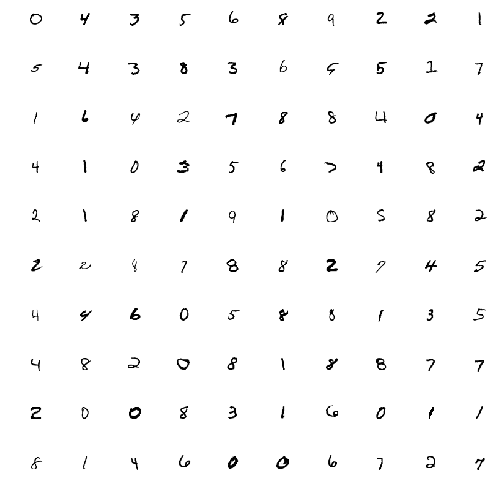

In [7]:
plot_100_imgs(x_train)

Now that we have seen the images. Let's convert each of them to a vector of size 784!

In [8]:
x_train = x_train.reshape((-1, 784))
x_test = x_test.reshape((-1, 784))

x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [9]:
y_train.dtype, y_test.dtype

(dtype('uint8'), dtype('uint8'))

## Cool Stuff Start's here!

Let's define our 1 layer model. First we need a way to send in three parameters.
* A batch of images. We will train our model on more than 1 image at a time but we will restrain from training model on all images at a single time. This ensures that the model trains fast (compared to training on 1 image at a time) without causing a burden over memory (when all the data is pushed into the network). There are other benefits of using batches for training. [read here](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/) 
* A batch of image labels.
* Learning rate for the model. Gradient Descent, the optimization algorithm we will deploy for training our model, requires a hyperparameter called learning rate. Learning rate, as the name suggests, refer to the rate at which the network changes its weights in accordance to the loss function. If its too large the network can diverge and lead to poor performance. If its too small the network will take forever to converge!

In [10]:
input_batch = tf.placeholder(tf.float32, [None, 784])
labels = tf.placeholder(tf.uint8, [None])
learning_rate = tf.placeholder(tf.float32)

Let's define our weights and biases. Weights will be a matrix of shape 784x10. And biases will be of shape 1x10

In [11]:
W = tf.Variable(tf.random_normal([784, 10]))
b = tf.Variable(tf.zeros([1, 10]))

Let's find the weighted sum and apply softmax!

In [12]:
logits = tf.add(tf.matmul(input_batch, W), b)
probs = tf.nn.softmax(logits)

True value (or labels) for a probability distribution of an image will represent a vector of length 10 with each value being 0, except the value of position, which represents the digit in image, being 1. This encoding is called one hot encoding. We will be using this to find cost of each image (cost of being wrong) in batch and then will calculate the total loss by calculating mean of these costs!

We will calculate the cost of each image by calculating log loss for each digit and adding them up.

$$Logloss(y, yhat) = \sum_{i=0}^{i=10}ylog(yhat)$$

Here,
* $y$: is the true probability distribution
* $yhat$: is the predicted probability distribution

In [13]:
one_hot_labels = tf.one_hot(labels, 10)
cost = tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_labels, logits=logits)
loss = tf.reduce_mean(cost)

Let's define the graph for accuracy!

In [14]:
is_equal = tf.equal(tf.argmax(probs, -1), tf.argmax(one_hot_labels, -1))
accuracy = tf.reduce_mean(tf.cast(is_equal, tf.float32))

Finally, let's define an optimizer object and ask it to minimize the loss!

In [15]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

Don't forget to define the variable intialization node!

In [16]:
init = tf.global_variables_initializer()

It is important to note that till this point we have just defined the graph. Now the task is to train the graph. For this we will first need to define certain constants. Let's define them!

In [17]:
EPOCHS = 10 # we will run graph for 10 epochs
BATCH_SIZE = 32 # We will ask optimizer to optimize our model over 32 images at a time
LEARNING_RATE = 1e-2 # we will be learning 0.01 times (or 1% of what we can learn) from every batch!
VAL_SPLIT = 0.2 # we will be keeping 20% of validation data and 80% of training data!

An epoch represents one iteration over training data while training the model. So if we train for 10 epochs we are essentially stating that we will make our model to have a look at every single image in training data 10 times!

Let's separate training data from validation data!

In [18]:
(x_train, y_train), (x_val, y_val) = train_val_split(x_train, y_train, VAL_SPLIT)

x_train.shape, x_val.shape

((48000, 784), (12000, 784))

Initialize a session object and then use it to initialize all the variables!

In [19]:
sess = tf.Session()

sess.run(init)

Throughout the training we will keep track of loss and accuracy over training and validation data respectively, at the end of each epoch. Let's define an object that can hold these values for us!

In [20]:
history = {
    'loss': [],
    'accuracy': [],
    'val_acc': [],
    'val_loss': []
}

Finally, let's train our model over the training data!

In [21]:
for epoch in range(EPOCHS): # for each epoch
    # shuffle the training data.
    x_train, y_train = shuffle(x_train, y_train)

    # Iterate over batch of images
    for batch_start in range(0, x_train.shape[0], BATCH_SIZE):
        # collect batches of images and their labels
        x_batch = x_train[batch_start:batch_start + BATCH_SIZE]
        y_batch = y_train[batch_start:batch_start + BATCH_SIZE]
        # finally let's train our model by calling training operation and feeding in required data
        sess.run(train_op, feed_dict={input_batch: x_batch, labels: y_batch, learning_rate: LEARNING_RATE})

    # after every epoch save the loss and accuracy. This displays us improvement of model in this epoch!
    train_loss, train_acc = sess.run([loss, accuracy], feed_dict={input_batch: x_train, labels: y_train})
    val_loss, val_acc = sess.run([loss, accuracy], feed_dict={input_batch: x_val, labels: y_val})

    history['loss'].append(train_loss)
    history['accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # let's print theese out as well!
    print('Epoch: {}/{} loss:{:.2f} acc:{:.2f} '
          'val_loss:{:.2f} val_acc:{:.2f}'.format(epoch+1, EPOCHS, train_loss, train_acc, val_loss, val_acc))

Epoch: 1/10 loss:242.46 acc:0.87 val_loss:256.25 val_acc:0.87
Epoch: 2/10 loss:319.99 acc:0.84 val_loss:336.09 val_acc:0.83
Epoch: 3/10 loss:245.66 acc:0.87 val_loss:254.78 val_acc:0.87
Epoch: 4/10 loss:378.37 acc:0.82 val_loss:414.01 val_acc:0.81
Epoch: 5/10 loss:203.98 acc:0.89 val_loss:222.22 val_acc:0.88
Epoch: 6/10 loss:201.06 acc:0.90 val_loss:226.89 val_acc:0.89
Epoch: 7/10 loss:210.84 acc:0.89 val_loss:231.60 val_acc:0.89
Epoch: 8/10 loss:236.36 acc:0.88 val_loss:266.78 val_acc:0.88
Epoch: 9/10 loss:238.98 acc:0.87 val_loss:269.75 val_acc:0.87
Epoch: 10/10 loss:190.35 acc:0.90 val_loss:214.09 val_acc:0.90


### Comparing loss over training and validation set!

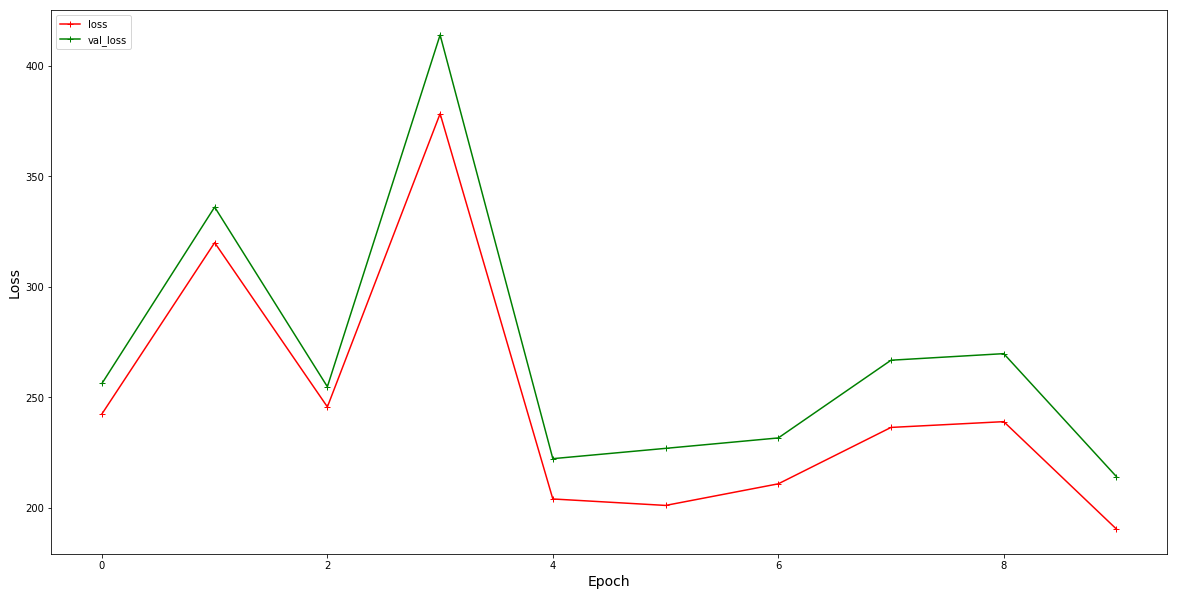

In [22]:
plt.figure(figsize=(20, 10))
plt.plot(history['loss'], 'r+-', label='loss')
plt.plot(history['val_loss'], 'g+-', label='val_loss')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper left');

### Comparing accuracy over training and validation set!

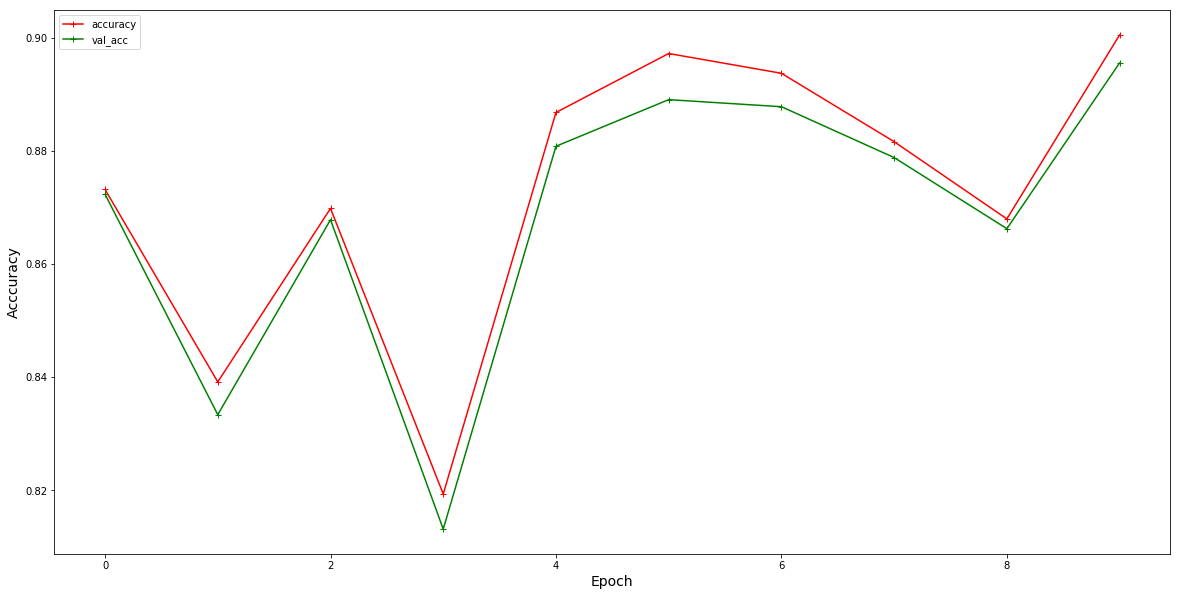

In [23]:
plt.figure(figsize=(20, 10))
plt.plot(history['accuracy'], 'r+-', label='accuracy')
plt.plot(history['val_acc'], 'g+-', label='val_acc')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Acccuracy', fontsize=14)
plt.legend(loc='upper left');

## Loss and Accuracy over Test Set!

In [24]:
acc, l = sess.run([accuracy, loss], feed_dict={input_batch: x_test, labels: y_test})
print('Test set - Accuracy: {:.2f} Loss: {:.2f}'.format(acc, l))

Test set - Accuracy: 0.89 Loss: 220.76


### Weights Visualization
Now let's look at the weights for each digit. Remember that our weights matrix is 784x10. So, each column represents weights for corresponding digit. Let's plot them and see if these weights have an underlying meaning!

In [25]:
weights, bias = sess.run([W, b])

In [26]:
weights.shape

(784, 10)

In [27]:
w_min = np.min(weights)
w_max = np.max(weights)

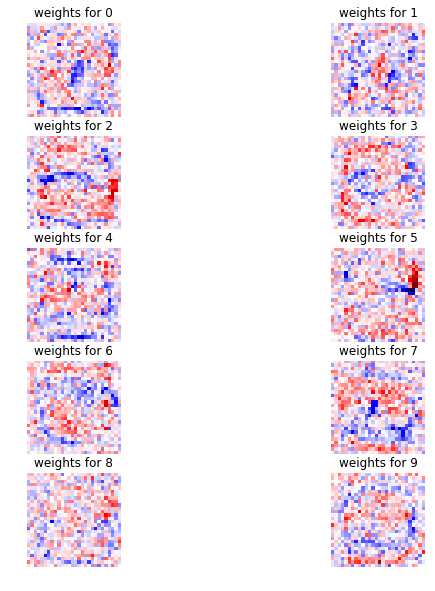

In [28]:
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.imshow(weights[:, i].reshape((28, 28)), vmax=w_max, vmin=w_min, cmap='seismic')
    plt.title('weights for {}'.format(i))
    plt.axis('off')
plt.show();

Looking closely you will be able to see the imprints of the digits they represent! Training them further will improve the imprints of the digits in the weights till a certain limit.

In [29]:
sess.close()